 corners : 
           
 create   : 2019/10/16
 modified : 2019/10/19

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
# RGB2GRAY
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

In [3]:
# convolution 2D
def conv2d(img, kernel, padding='same'):
    # Error handling
    if kernel.shape[0] != kernel.shape[1]:
        print("Use square filter!")
        return None
    
    if kernel.shape[0]%2 == 0 and kernel.shape[1]%2 == 0:
        print("filter size has to be odd")
        return None
    
    # Create result matrix
    result = np.zeros_like(img)
    
    # Calculate kernel size
    kernel_size = kernel.shape[0]
    
    # same padding
    if padding=='same':
        pad_size = int((kernel_size - 1) / 2)
    else:
        pad_size = 0
    img = np.pad(img, pad_size, mode='constant')
    
    # convolution
    width, height = img.shape
    offset = int(kernel_size / 2)
    for x in range(offset, width-offset):
        for y in range(offset, height-offset):
            result[x-offset, y-offset] = np.sum(img[x-offset:x+offset+1, y-offset:y+offset+1] * kernel)
            
    return result

In [4]:
# to define gradient x-axis with sobel filter
def grad_x(img):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return conv2d(img, kernel=sobel_x)

In [5]:
# to define gradient y-axis with sobel filter
def grad_y(img):
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return conv2d(img, kernel=sobel_y)

In [6]:
def cornerDetect(img, winSize=7, k=0.04, thd=1, type=0):
    """
    Parameters:
        img     = image (grayscale)
        winSize = total size of window for summation in pixels
        k       = empirical constant
        thd     = threshold
        type    = {0 - Eigenvalue, 1 - Harris}
    """
   
    # create empty matrix for result
    result = np.zeros_like(img)
    
    # get image size
    width, height = img.shape
    
    # compute derivatives using sobel kernel
    dx = grad_x(img)
    dy = grad_y(img)
    
    # For each pixel in img, determine second moment matrix H summed up over the window
    Ixx = dx ** 2
    Ixy = dy * dx
    Iyy = dy ** 2
    
    # Create matrix for saving second moment
    Sxx = np.zeros_like(Ixx)
    Sxy = np.zeros_like(Ixy)
    Syy = np.zeros_like(Iyy)
    
    # same padding
    pad_size = int((winSize - 1) / 2)
    Ixx = np.pad(Ixx, pad_size, mode='constant')
    Ixy = np.pad(Ixy, pad_size, mode='constant')
    Iyy = np.pad(Iyy, pad_size, mode='constant')
    
    # Calculate second moment matrix H summed up over the window
    offset = int(winSize / 2)
    for x in range(offset, width-offset):
        for y in range(offset, height-offset):
            Sxx[x-offset, y-offset] = np.sum(Ixx[x-offset:x+offset+1, y-offset:y+offset+1])
            Sxy[x-offset, y-offset] = np.sum(Ixy[x-offset:x+offset+1, y-offset:y+offset+1])
            Syy[x-offset, y-offset] = np.sum(Iyy[x-offset:x+offset+1, y-offset:y+offset+1])
        
    # Eigenvalue
    if type==0:
        #lamda1 = (Sxx + Syy) + np.sqrt(4*Sxy**2 + (Sxx-Syy)**2)
        lamda2 = (Sxx + Syy) - np.sqrt(4*Sxy**2 + (Sxx-Syy)**2) # always minimum
        minLamda = lamda2
        result = minLamda
        result[result < thd] = 0
        
    # Harris
    elif type==1:
        det = (Sxx * Syy) - (Sxy**2)
        trace = Sxx + Syy
        r = det - k*(trace**2)
        result = r
        result[result < thd] = 0

    return result

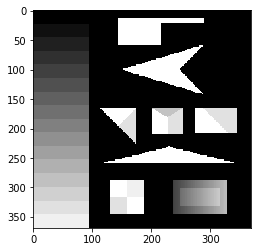

In [7]:
# read image
img = mpl.image.imread("img74.gif")
img = rgb2gray(img)
plt.imshow(img, cmap='gray')

In [8]:
# set empiracal constant(0.04 ~ 0.06), threshold
k = 0.04
thd = 10

# given window size
winSizes = [3,5,7,9,11,15,21]

Text(0.5, 1, 'Minimum eigenvalue corner detection')

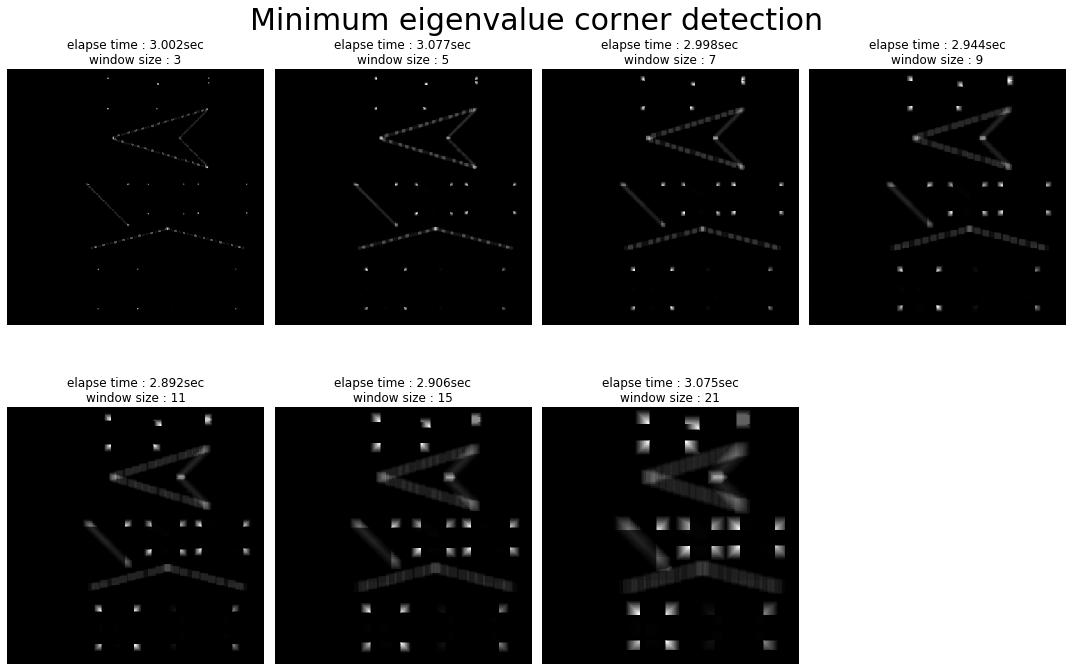

In [9]:
# type0 (eigenvalue)
fig = plt.figure(figsize= (15,10))
T0_runtime = []
for idx in range(len(winSizes)) :
    sTime = time.time()
    result = cornerDetect(img, winSize=winSizes[idx], k=k, thd=thd, type=0)
    eTime = time.time()
    ax = fig.add_subplot(2, 4, idx+1)    
    ax.imshow(result, cmap='gray')
    ax.set_title("elapse time : %.3fsec\nwindow size : %d" %((eTime-sTime), winSizes[idx]))
    ax.axis('off')
    T0_runtime.append(eTime-sTime)
plt.tight_layout()
plt.suptitle('Minimum eigenvalue corner detection', fontsize = 30, y = 1)

Text(0.5, 1, 'Harris corner detection')

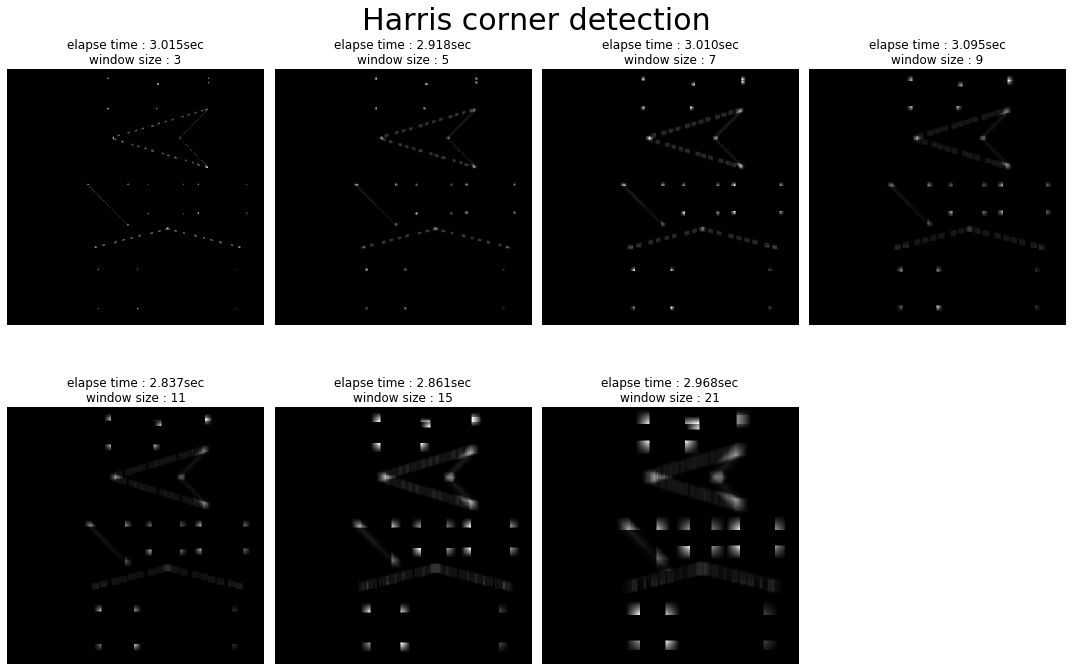

In [10]:
# type1 (Harris detector)
fig = plt.figure(figsize= (15,10))
T1_runtime = []
for idx in range(len(winSizes)) :
    sTime = time.time()
    result = cornerDetect(img, winSize=winSizes[idx], k=k, thd=thd, type=1)
    eTime = time.time()
    ax = fig.add_subplot(2, 4, idx+1)    
    ax.imshow(result, cmap='gray')
    ax.set_title("elapse time : %.3fsec\nwindow size : %d" %((eTime-sTime), winSizes[idx]))
    ax.axis('off')
    T1_runtime.append(eTime-sTime)
plt.tight_layout()
plt.suptitle('Harris corner detection', fontsize = 30, y = 1)

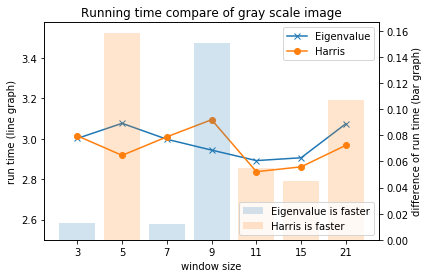

In [11]:
x_axis = ['3','5','7','9','11','15','21']
dif_up = []
dif_down = []

#calculate the difference of runtime each window size 
difference = np.array(T0_runtime)-np.array(T1_runtime)
for dif in difference:
    if dif > 0:
        dif_up.append(dif)
        dif_down.append(0)
    else:
        dif_down.append(dif)
        dif_up.append(0)
        
fig, ax1 =  plt.subplots()
ax1.plot(x_axis,T0_runtime,'-x', label = 'Eigenvalue')
ax1.plot(x_axis,T1_runtime, '-o', label = 'Harris')
ax1.set_ylim([2.5, max(max(T0_runtime)+0.5,max(T1_runtime))])
ax1.set_ylabel('run time (line graph)')
ax1.set_xlabel('window size')
plt.legend(loc=1)
ax2 = ax1.twinx()
ax2.bar(x_axis,abs(np.array(dif_down)), label = 'Eigenvalue is faster', alpha = 0.2)
ax2.bar(x_axis,abs(np.array(dif_up)), label = 'Harris is faster', alpha = 0.2)
ax2.set_ylabel('difference of run time (bar graph)')
plt.legend(loc=4)
plt.title('Running time compare of gray scale image')
plt.show()

In [12]:
# deinfe corner detector about color image
def cornerDetectColor(img, winSize=7, k=0.04, thd=1, type=0):
    result_gray = cornerDetect(rgb2gray(img.copy() * 255), winSize, k, thd, type)
    result = img.copy()
    result[result_gray > 0, 0] = 0
    result[result_gray > 0, 1] = 0
    result[result_gray > 0, 2] = 1

    return result

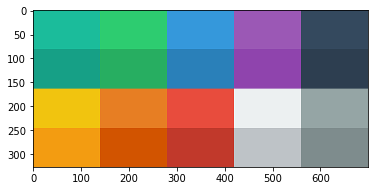

In [13]:
# image load
img = mpl.image.imread("img_color.png")
plt.imshow(img)

Text(0.5, 1.01, 'minimum eigenvalue corner detection')

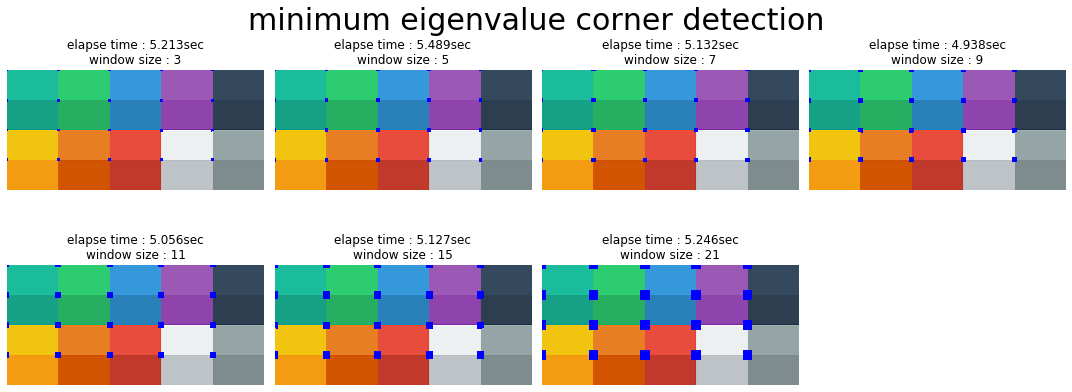

In [17]:
# type0 (eigenvalue)
fig = plt.figure(figsize= (15,6))
T0_runtime_c = []
for idx in range(len(winSizes)) :
    sTime = time.time()
    result = cornerDetectColor(img, winSize=winSizes[idx], k=k, thd=thd, type=0)
    eTime = time.time()
    ax = fig.add_subplot(2, 4, idx+1)    
    ax.imshow(result)
    ax.axis('off')
    ax.set_title("elapse time : %.3fsec\nwindow size : %d" %((eTime-sTime), winSizes[idx]))
    T0_runtime_c.append(eTime-sTime)
plt.tight_layout()
plt.suptitle('minimum eigenvalue corner detection', fontsize = 30, y = 1.01)

Text(0.5, 1.01, 'Harris corner detection')

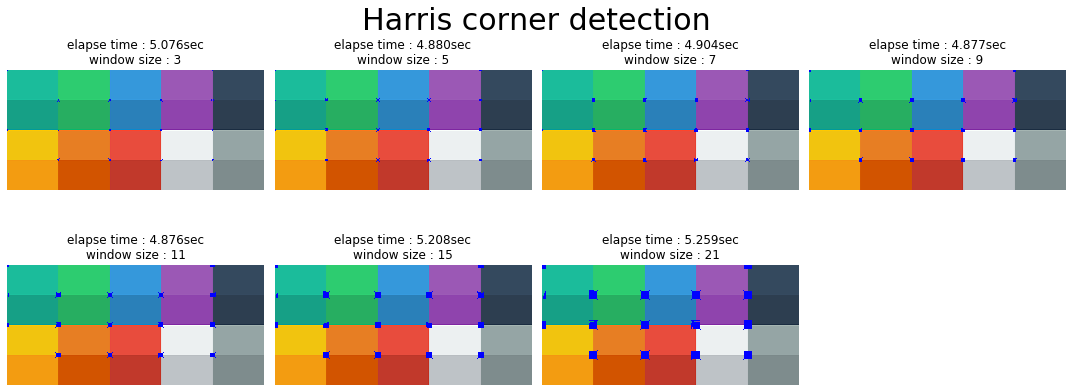

In [18]:
# type1 (Harris detector)
fig = plt.figure(figsize= (15,6))
T1_runtime_c = []
for idx in range(len(winSizes)) :
    sTime = time.time()
    result = cornerDetectColor(img, winSize=winSizes[idx], k=k, thd=thd, type=1)
    eTime = time.time()
    ax = fig.add_subplot(2, 4, idx+1)    
    ax.imshow(result)
    ax.set_title("elapse time : %.3fsec\nwindow size : %d" %((eTime-sTime), winSizes[idx]))
    ax.axis('off')
    T1_runtime_c.append(eTime-sTime)
plt.tight_layout()
plt.suptitle('Harris corner detection', fontsize = 30, y = 1.01)

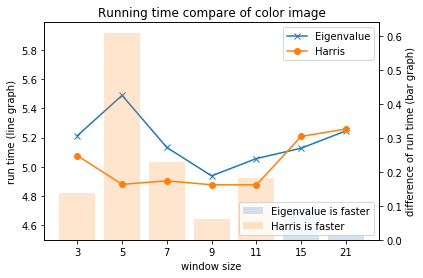

In [19]:
# running time compare of colorimage
x_axis = ['3','5','7','9','11','15','21']
dif_up1 = []
dif_down1 = []

#calculate the difference of runtime each window size 
difference_c = np.array(T0_runtime_c)-np.array(T1_runtime_c)
for idx, dif in enumerate(difference_c):
    if dif > 0:
        dif_up1.append(dif)
        dif_down1.append(0)
    else:
        dif_down1.append(dif)
        dif_up1.append(0)
        
fig, ax1 =  plt.subplots()
ax1.plot(x_axis,T0_runtime_c,'-x', label = 'Eigenvalue')
ax1.plot(x_axis,T1_runtime_c, '-o', label = 'Harris')
ax1.set_ylim([4.5, max(max(T0_runtime_c)+0.5,max(T1_runtime_c))])
ax1.set_ylabel('run time (line graph)')
ax1.set_xlabel('window size')
plt.legend(loc=1)
ax2 = ax1.twinx()
ax2.bar(x_axis,abs(np.array(dif_down1)), label = 'Eigenvalue is faster', alpha = 0.2)
ax2.bar(x_axis,abs(np.array(dif_up1)), label = 'Harris is faster', alpha = 0.2)
ax2.set_ylabel('difference of run time (bar graph)')
plt.legend(loc=4)
plt.title('Running time compare of color image')
plt.show()

### 1) At which window sizes can you detect all “meaningful” corners?

![fig1.jpg](fig1.jpg)
follow this figure, we can see that the same corners can be detected even by changing the window size

but, 

![fig2.jpg](fig2.jpg)
follow this figure, larger the window size, It weems the more corners it detects

So we think the window size of 7 or more is good.

### 2) Which method is faster – Eigenvalue or Harris? By how much?

Each iteration of the test yielded different results.

![image.png](fig3.jpg)

However, the above table shows that the speed of harris corner detection is faster due to a slight difference within 0.5sec.